In [11]:
%load_ext autoreload
%autoreload 2

# Add other paths
import os, sys
sys.path.append(os.path.abspath(os.path.join("../")))
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn.metrics
import glob
import datetime as dt
from sklearn.metrics import r2_score
from tqdm.auto import tqdm

import helper_libraries.results_tools as results_tools
sns.set_context("paper", font_scale=1.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import Data

In [2]:
# Load returns and spreads
fret_df, hrf_df = results_tools.load_mkt_rf_returns()
spread_df = results_tools.load_spreads()

# Main

## Params

In [3]:
## Params
# List of all results folders
results_folders = (
    pd.read_excel("../../results/key.xlsx").query('"Done" in Notes')["Folder"].to_list()
)  ##### <------------------ Finish models!
# Year to start trading
start_year = "2004"

# Define strategies and models
strategies_list = [
    "Market",
] + [f'MS Strategy {x:.2f}' for x in np.linspace(0, 5, 200)]
model_list = ["Enet"]

# Metrics and their names
metrics_list = ["Return", "ReturnAdj", "Sharpe", "SharpeAdj", "Trades", "rvol"]
metrics_names_list = [
    "Return",
    "Adjusted Return",
    "Sharpe",
    "Adjusted Sharpe",
    "Trades",
    "Realized Volatility",
]

## Load results

In [4]:
## Load data
forecast_oss_df, forecast_ins_df, results_folder_name = results_tools.load_model_results(
    folder_name = 'main', debug=True
)

In [5]:
## Get trading results
# Filter data
forecast_oss_filter_df = forecast_oss_df.loc[start_year:]
forecast_ins_filter_df = forecast_ins_df.loc[:str(int(start_year)-1)].copy()
fret_filter_df = fret_df.loc[start_year:]
hrf_filter_df = hrf_df.loc[start_year:]

# Trading strategies
(
    oss_results_all_df,
    oss_returns_all_df,
    oss_weights_all_df,
    oss_retpred_all_df,
) = results_tools.get_trading_results(
    forecast_oss_filter_df,
    forecast_ins_filter_df,
    spread_df,
    fret_filter_df['ff__mkt'],
    hrf_filter_df['rf'],
    strategies_list,
    model_list,
    hold_cash=True,
)

In [6]:
oss_results_all_df["cutoff"] = pd.Series(oss_results_all_df.index).apply(
    lambda x: pd.to_numeric(x.split("Strategy ")[-1], errors="coerce")
).values

n_years = (forecast_oss_filter_df.index.max() - forecast_oss_filter_df.index.min()).days / 365
oss_results_all_df['Turnover'] = oss_results_all_df['Trades'] * n_years / len(forecast_oss_filter_df)

In [7]:
oss_results_all_df

,Return,ReturnAdj,Trades,Sharpe,SharpeAdj,rvol,Name (col),Name,cutoff,Turnover
Market,0.0153,0.0153,0.0,0.026,0.026,0.142,oss_Enet,Enet,NaN,0.000000
MS Strategy 0.00,0.1289,0.0796,1343.5,0.970,0.562,0.121,oss_Enet,Enet,0.00,0.205343
MS Strategy 0.03,0.1298,0.0811,1325.0,0.982,0.578,0.120,oss_Enet,Enet,0.03,0.202515
MS Strategy 0.05,0.1298,0.0816,1314.0,0.984,0.583,0.120,oss_Enet,Enet,0.05,0.200834
MS Strategy 0.08,0.1343,0.0869,1292.8,1.025,0.629,0.120,oss_Enet,Enet,0.08,0.197594
...,...,...,...,...,...,...,...,...,...,...
MS Strategy 4.90,-0.0023,-0.0024,2.8,-0.882,-0.889,0.016,oss_Enet,Enet,4.90,0.000428
MS Strategy 4.92,-0.0023,-0.0024,2.6,-0.886,-0.893,0.016,oss_Enet,Enet,4.92,0.000397
MS Strategy 4.95,-0.0023,-0.0024,2.5,-0.883,-0.890,0.016,oss_Enet,Enet,4.95,0.000382
MS Strategy 4.97,-0.0023,-0.0024,2.5,-0.883,-0.890,0.016,oss_Enet,Enet,4.97,0.000382


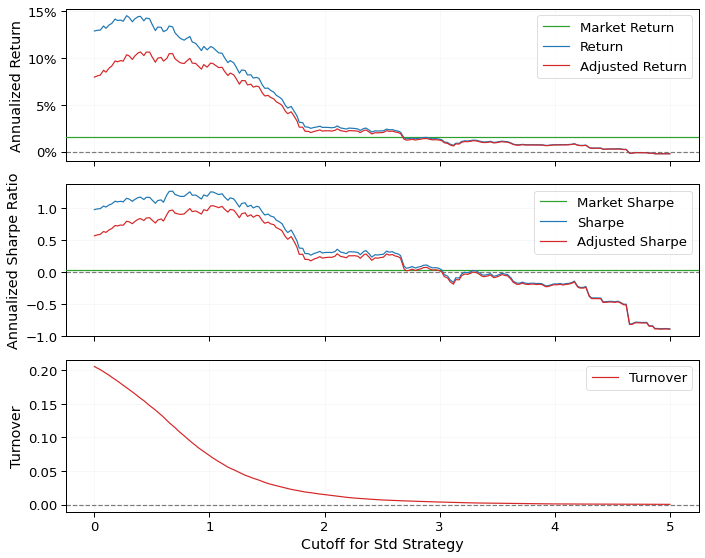

In [12]:
fig, axs = plt.subplots(figsize=(10, 8), nrows=3, sharex = True)

ax = axs[0]
ax.axhline(0, color="k", ls="--", alpha=0.5, zorder=5)
ax.axhline(
    oss_results_all_df.loc["Market", "Return"],
    color="tab:green",
    label="Market Return",
    ls="-",
    alpha=1,
    zorder=5,
)
oss_results_all_df.dropna().plot(x="cutoff", y="Return", label="Return", ax=ax, zorder=15)
oss_results_all_df.dropna().plot(
    x="cutoff", y="ReturnAdj", label="Adjusted Return", color="tab:red", ax=ax, zorder=15
)
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1, decimals=0))
ax.legend()
ax.set_ylabel('Annualized Return')

ax = axs[1]
ax.axhline(0, color="k", ls="--", alpha=0.5, zorder=5)
ax.axhline(
    oss_results_all_df.loc["Market", "Sharpe"],
    color="tab:green",
    label="Market Sharpe",
    ls="-",
    alpha=1,
    zorder=5,
)
oss_results_all_df.dropna().plot(x="cutoff", y="Sharpe", label="Sharpe", ax=ax, zorder=15)
oss_results_all_df.dropna().plot(
    x="cutoff", y="SharpeAdj", label="Adjusted Sharpe", color="tab:red", ax=ax, zorder=15
)
ax.set_ylabel('Annualized Sharpe Ratio')
ax.legend()

ax = axs[2]
ax.axhline(0, color="k", ls="--", alpha=0.5, zorder=5)
oss_results_all_df.dropna().plot(x="cutoff", y="Turnover", label="Turnover", color = 'tab:red', ax=ax, zorder=15)
plt.tight_layout()
ax.set_ylabel('Turnover')
ax.set_xlabel('Cutoff for Std Strategy')

for ax in axs.reshape(-1):
    ax.grid(alpha=0.1)   

fig.savefig('../../docs/exhibits/figures/ms_strategy_cutoff_results.pdf')

In [14]:
(1.09)**16

3.9703058810594016

In [ ]:
np.

2.718281828459045